In [1]:
## Import Packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Concatenate, Reshape, Multiply, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from time import time
import sys, os, argparse
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('talk')

## Read in toronto user-item interaction csv file to generate dataset:

### !!!WARNING!!! MAKE SURE TO RUN 'Data_Cleaning_&_Baseline1.ipynb' BEFORE RUNNING THIS FILE

In [2]:
toronto_user_item_final_df = pd.read_csv('../yelp_dataset/toronto_user_item_final_df.csv', index_col = 0)
dataset_to_use = toronto_user_item_final_df.copy()

In [3]:
num_users = dataset_to_use.user_id.nunique()
num_items = dataset_to_use.business_id.nunique()

In [4]:
len(dataset_to_use)

227663

In [5]:
print('There are %d unique users and %d unique items in the dataset after filtering such that each user has \
reviewed at least 10 restaurants.'%(num_users, num_items))

There are 7905 unique users and 8546 unique items in the dataset after filtering such that each user has reviewed at least 10 restaurants.


In [6]:
dataset_to_use.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,1,0,0,0,0,1,0,0,0,0
1,gAxeeJKwJtxp3uH9zUQ2aQ,A-Game Cafe,797 Dundas Street W,toronto,ON,M6J 1V2,43.651719,-79.407911,4.5,91,...,1,0,0,0,0,1,0,0,0,0
2,cWPTOM_o5toaXpq0gNxD7Q,Vanta Coffee Club & Eatery,2101 Brimley Road,toronto,ON,M1S 2B4,43.788839,-79.268636,4.0,204,...,1,0,0,0,0,1,0,0,0,0


### Create simpler IDs for users and items

In [7]:
unique_business_id = dataset_to_use.business_id.unique()
mapping_business_id = {}
ctr = 0
for business_id in unique_business_id:
    mapping_business_id[business_id] = ctr
    ctr += 1
    
dataset_to_use['business_id_refined'] = dataset_to_use.business_id.map(mapping_business_id)

In [8]:
unique_user_id = dataset_to_use.user_id.unique()
mapping_user_id = {}
ctr = 0
for user_id in unique_user_id:
    mapping_user_id[user_id] = ctr
    ctr += 1
    
dataset_to_use['user_id_refined'] = dataset_to_use.user_id.map(mapping_user_id)

In [9]:
dataset_to_use[['user_id_refined', 'business_id_refined']].head(5)

,user_id_refined,business_id_refined
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


# User Attributes:

### Choose top n each to be final features.
#### Smallest n for # final features>=60

In [10]:
import csv
Dish, Ingre = {}, {}

with open("Dish20000.csv", "r") as csvFile:
    reader = csv.reader(csvFile)
    for item in reader:
        Dish[item[0]] = int(item[1])
        
with open("Ingre20000.csv", "r") as csvFile:
    reader = csv.reader(csvFile)
    for item in reader:
        Ingre[item[0]] = int(item[1])

Dish = dict(sorted(Dish.items(), key=lambda item: item[1], reverse=1))
Ingre = dict(sorted(Ingre.items(), key=lambda item: item[1], reverse=1))

In [11]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def constructFeature(n_lim,Dish,Ingre):
    wnl = WordNetLemmatizer()

    n = int(n_lim/2)
    features = set()

    while len(features)<n_lim:
        n+=1
        features = set(list(Dish.keys())[:n]+list(Ingre.keys())[:n])
        features = set([str.lower(wrd) for wrd in features])
        features = set([wnl.lemmatize(wrd) for wrd in features]) # singluarization
        
    # Word "breakfast" not detected. Add to list.
    features = list(features) + ['breakfast']
    
    return features

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\somani4\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
n_lim = 19
features = constructFeature(n_lim,Dish,Ingre)
print(features)

num_of_user_features = len(features)
print(num_of_user_features)

['soup', 'fanta', 'absolut', 'coffee', 'beer', 'bowl', 'cocktail', 'noodle', 'curry', 'tea', 'dinner', 'sushi', 'lunch', 'pasta', 'pizza', 'fry', 'burger', 'fish', 'salad', 'brunch', 'breakfast']
21


In [13]:
num_of_features = num_of_user_features

In [14]:
user_features = np.zeros([num_users, len(features)])

for i in range(num_users):
    user_reviews = list(dataset_to_use[dataset_to_use.user_id_refined == i]['text'])
    for j in range(len(features)):
        for k in range(len(user_reviews)):
            review_temp = user_reviews[k].lower()
            if features[j] in review_temp:
                user_features[i,j] = 1
                
user_features.shape

(7905, 21)

### Create a dataframe for user attributes:

In [15]:
user_features_df = pd.DataFrame(data = user_features, 
                              columns = ['user_feature_' + str(i) for i in range(num_of_user_features)])
user_features_df.index.rename('user_id_refined', inplace = True)
user_features_df.reset_index(inplace = True)
user_features_df.head(3)

,user_id_refined,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,...,user_feature_11,user_feature_12,user_feature_13,user_feature_14,user_feature_15,user_feature_16,user_feature_17,user_feature_18,user_feature_19,user_feature_20
0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [16]:
# Merge user attributes with the dataframe
dataset_to_use = pd.merge(dataset_to_use, user_features_df, how = 'inner', on = 'user_id_refined')
dataset_to_use[['user_id_refined','business_id_refined'] + 
               ['user_feature_' + str(i) for i in range(num_of_user_features)]].head()

,user_id_refined,business_id_refined,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,...,user_feature_11,user_feature_12,user_feature_13,user_feature_14,user_feature_15,user_feature_16,user_feature_17,user_feature_18,user_feature_19,user_feature_20
0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,0,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,0,3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0,4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


# Item Attributes:

In [17]:
cat = dataset_to_use.categories.to_list()
all_buis_ids = dataset_to_use.business_id_refined.to_list()

buis_num = len(cat)
cat_2_count = {}
for string in cat:
    cats = string.split(", ")
    for cat1 in cats:
        if cat1 in cat_2_count.keys():
            cat_2_count[cat1] =  cat_2_count[cat1] + 1
        else:
            cat_2_count[cat1] = 1

cat_2_count.pop("Restaurants", None)
unique_cats = list(cat_2_count.keys())
unique_cats_count = list(cat_2_count.values())

# print(unique_cats[0], ":", unique_cats_count[0])
unique_cats_sorted = [x for _, x in sorted(zip(unique_cats_count, unique_cats), reverse= True)]

num_of_item_features = num_of_features
top_n_cats = unique_cats_sorted[:num_of_item_features]
one_hot_encoding_business = np.zeros((buis_num, num_of_item_features))

for i in range(buis_num):
    for j in range(num_of_item_features):
        if top_n_cats[j] in cat[i]:
            one_hot_encoding_business[i][j] = 1

buiz_id_to_encoding = {}

for i in range(len(all_buis_ids)):
    buiz_id_to_encoding[all_buis_ids[i]] = one_hot_encoding_business[i]

In [18]:
item_features_df = pd.DataFrame.from_dict(buiz_id_to_encoding, orient = 'index', 
                                             columns = ['item_feature_' + str(i) for i in range(num_of_item_features)])
item_features_df.sort_index(inplace = True)
item_features_df.index.rename('business_id_refined', inplace = True)
item_features_df.reset_index(inplace = True)
item_features_df.head(3)

,business_id_refined,item_feature_0,item_feature_1,item_feature_2,item_feature_3,item_feature_4,item_feature_5,item_feature_6,item_feature_7,item_feature_8,...,item_feature_11,item_feature_12,item_feature_13,item_feature_14,item_feature_15,item_feature_16,item_feature_17,item_feature_18,item_feature_19,item_feature_20
0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
item_features_df.shape

(8546, 22)

In [20]:
# Merge item attributes with the dataframe
dataset_to_use = pd.merge(dataset_to_use, item_features_df, how = 'inner', on = 'business_id_refined')
dataset_to_use[['user_id_refined','business_id_refined'] + 
               ['item_feature_' + str(i) for i in range(num_of_item_features)]].head()

,user_id_refined,business_id_refined,item_feature_0,item_feature_1,item_feature_2,item_feature_3,item_feature_4,item_feature_5,item_feature_6,item_feature_7,...,item_feature_11,item_feature_12,item_feature_13,item_feature_14,item_feature_15,item_feature_16,item_feature_17,item_feature_18,item_feature_19,item_feature_20
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
dataset_to_use.sort_values(by = ['user_id_refined', 'date'], inplace = True)
dataset_to_use.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,item_feature_11,item_feature_12,item_feature_13,item_feature_14,item_feature_15,item_feature_16,item_feature_17,item_feature_18,item_feature_19,item_feature_20
816,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Test Data:

In [22]:
def last_value(df):
    return df.iloc[[-1]]

In [23]:
# Save the most recent visit to a restaurant as the test data
test_data = dataset_to_use.groupby('user_id_refined').apply(last_value)

In [24]:
test_data = test_data.droplevel(0)
test_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,item_feature_11,item_feature_12,item_feature_13,item_feature_14,item_feature_15,item_feature_16,item_feature_17,item_feature_18,item_feature_19,item_feature_20
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,1262 Don Mills Road,toronto,ON,M3B 2W7,43.744703,-79.346468,5.0,317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2784,B70iTJjcPkuYn8ouUewWgw,Gusto 101,101 Portland Street,toronto,ON,M5V 2N3,43.645002,-79.400309,4.0,956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9944,mVVoK2ADlKbvwitSqFY2hw,Pantry Foods,3456 Bathurst Street,toronto,ON,M6A 2C3,43.728130,-79.432020,4.0,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_test = np.array(test_data[['user_id_refined', 'business_id_refined'] +\
                            ['user_feature_' + str(i) for i in range(num_of_features)] +
                            ['item_feature_' + str(i) for i in range(num_of_features)]].values.tolist())
X_test

array([[0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 1.900e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 6.400e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [7.902e+03, 1.841e+03, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.903e+03, 9.300e+02, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.904e+03, 2.265e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [26]:
X_test.shape

(7905, 44)

In [27]:
y_test = np.array(test_data['stars']) / 5.0 # Normalize the ratings to fall within [0, 1]
y_test

array([1. , 0.6, 1. , ..., 0.8, 0.2, 0.2])

In [28]:
len(y_test) == len(X_test)

True

## Train Data:

In [29]:
# Save all visits to a restaurant except the last one as the train data
def all_values_except_last(df):
    return df.iloc[:-1]

In [30]:
train_data = dataset_to_use.groupby('user_id_refined').apply(all_values_except_last)

In [31]:
train_data = train_data.droplevel(0)
train_data.head(3)

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_business_avg,review_count_x,...,item_feature_11,item_feature_12,item_feature_13,item_feature_14,item_feature_15,item_feature_16,item_feature_17,item_feature_18,item_feature_19,item_feature_20
816,e49eXgKVuR-lsL0-D4vzDw,Momiji,2111 Sheppard Avenue E,toronto,ON,M2J 1W6,43.775377,-79.333972,3.0,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,1310 Don Mills Road,toronto,ON,M3B 2W6,43.745920,-79.346301,3.5,119,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,Nz44ccUso3nq5S2OlQHNlA,Mexico Lindo,"2600 Birchmount Road, Suite 2586",toronto,ON,M1T 2M5,43.789719,-79.302981,4.0,163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
len(train_data), len(test_data), len(train_data) + len(test_data) == len(dataset_to_use)

(219758, 7905, True)

In [33]:
X_train = np.array(train_data[['user_id_refined','business_id_refined'] +
                              ['user_feature_' + str(i) for i in range(num_of_features)] + 
                              ['item_feature_' + str(i) for i in range(num_of_features)]].values.tolist())
X_train

array([[0.000e+00, 1.200e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.000e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 3.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [7.904e+03, 8.045e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.904e+03, 8.480e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.904e+03, 6.951e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [34]:
X_train.shape

(219758, 44)

In [35]:
y_train = np.array(train_data['stars']) / 5.0 # Normalize the ratings to fall within [0, 1]
y_train

array([0.6, 0.6, 1. , ..., 0.6, 0.4, 0.2])

In [36]:
len(y_train) == len(X_train)

True

In [37]:
def get_train_instances(X, y):
    X = np.array(X)
    users, items, user_features, item_features = X[:, 0], X[:, 1], X[:, 2: num_of_features + 2], X[:, num_of_features + 2:]
    ratings = y
    
    return users, items, user_features, item_features, ratings

# (1) GMF Implementation:

In [38]:
def get_gmf_model(num_users, num_items, regs = [0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')
    user_feature_input = Input(shape = (num_of_features, ), dtype='float32', name = 'user_feature_input')
    item_feature_input = Input(shape = (num_of_features, ), dtype='float32', name = 'item_feature_input')

    MF_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = num_of_features, name = 'user_embedding',
                                     embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[0]),
                                     input_length = 1)
    MF_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = num_of_features, name = 'item_embedding',
                                     embeddings_initializer='random_normal', embeddings_regularizer = l2(regs[1]),
                                     input_length = 1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User_ID(user_input))
    item_latent = Flatten()(MF_Embedding_Item_ID(item_input))
    
    # Element-wise product for user and item layers
    user_feature_latent = Multiply()([user_latent, user_feature_input])
    item_feature_latent = Multiply()([item_latent, item_feature_input])
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_feature_latent, item_feature_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs = [user_input, item_input, user_feature_input, item_feature_input], outputs = prediction)

    return model

In [39]:
def evaluate_model(model, X, y):
    """
    Return: score of each test rating.
    """
    users, items, user_features, item_features, ratings = get_train_instances(X, y)
        
    predictions = model.predict([users, items, user_features, item_features], batch_size = 1000, verbose = 0)

    y_actual = np.array(y) * 5
    y_pred = np.array(predictions) * 5
    assert len(y_pred) == len(y_actual)
    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    return (mse, r2)

In [40]:
# Build model
regs = [0, 0]
learner = 'adam'
learning_rate = 0.0005
num_epochs = 20
batch_size = 256
out = 1

model = get_gmf_model(num_users, num_items, regs)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Initial: Test RMSE = 1.7351, Test R2 = -0.8242


C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [1.8 s]: Test RMSE = 1.4633, Test R2 = -0.2975, Train RMSE = 1.4277 [0.1 s]
Epoch 2 [1.3 s]: Test RMSE = 1.3400, Test R2 = -0.0880, Train RMSE = 1.2215 [0.1 s]
Epoch 3 [1.3 s]: Test RMSE = 1.2983, Test R2 = -0.0214, Train RMSE = 1.1412 [0.1 s]
Epoch 4 [1.3 s]: Test RMSE = 1.2878, Test R2 = -0.0049, Train RMSE = 1.1180 [0.1 s]
Epoch 5 [1.6 s]: Test RMSE = 1.2859, Test R2 = -0.0020, Train RMSE = 1.1100 [0.1 s]
Epoch 6 [1.3 s]: Test RMSE = 1.2861, Test R2 = -0.0023, Train RMSE = 1.1011 [0.1 s]
Epoch 7 [1.3 s]: Test RMSE = 1.2871, Test R2 = -0.0038, Train RMSE = 1.0884 [0.1 s]
Epoch 8 [1.4 s]: Test RMSE = 1.2893, Test R2 = -0.0072, Train RMSE = 1.0732 [0.1 s]
Epoch 9 [1.4 s]: Test RMSE = 1.2923, Test R2 = -0.0120, Train RMSE = 1.0571 [0.1 s]
Epoch 10 [1.4 s]: Test RMSE = 1.2964, Test R2 = -0.0184, Train RMSE = 1.0414 [0.1 s]
Epoch 11 [1.3 s]: Test RMSE = 1.3008, Test R2 = -0.0253, Train RMSE = 1.0267 [0.1 s]
Epoch 12 [1.4 s]: Test RMSE = 1.3064, Test R2 = -0.0341, Train RMSE = 1.01

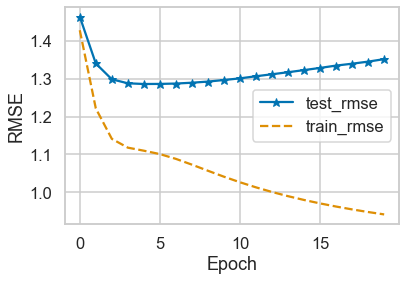

In [41]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_gmf = current_folder + '\\Pretrain\\toronto_GMF.h5'

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, user_feature_input, item_feature_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()
        
    # Training
    history = model.fit([user_input, item_input, user_feature_input, item_feature_input], # input
                         np.array(ratings), # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5) # multiply loss by 5 because the ratings are normalized by 5
    
    t2 = time()

    # Evaluation
    
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch + 1
        if out > 0:
            model.save_weights(model_out_file_gmf, overwrite = True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best GMF model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

# (2) MLP Implementation:

In [42]:
def get_mlp_model(num_users, num_items, layers = [20,10], reg_layers=[0,0]):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')
    user_feature_input = Input(shape = (num_of_features, ), dtype='float32', name = 'user_feature_input')
    item_feature_input = Input(shape = (num_of_features, ), dtype='float32', name = 'item_feature_input')
    
    MLP_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = num_of_features, name = 'user_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = num_of_features, name = 'item_embedding',
                                   embeddings_initializer='random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User_ID(user_input))
    item_latent = Flatten()(MLP_Embedding_Item_ID(item_input))
    
    # Element-wise product of user and item layers
    user_feature_latent = Multiply()([user_latent, user_feature_input])
    item_feature_latent = Multiply()([item_latent, item_feature_input])
    
    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate()([user_feature_latent, item_feature_latent])
    
    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs = [user_input, item_input, user_feature_input, item_feature_input], outputs = prediction)
    
    return model

In [43]:
# Build model
layers = [64,32,16,8]
reg_layers = [0,0,0,0]

model = get_mlp_model(num_users, num_items, layers, reg_layers)

if learner.lower() == "adagrad":
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Initial: Test RMSE = 1.7359, Test R2 = -0.8259


C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [2.0 s]: Test RMSE = 1.2196, Test R2 = 0.0987, Train RMSE = 1.1361 [0.1 s]
Epoch 2 [1.4 s]: Test RMSE = 1.1846, Test R2 = 0.1496, Train RMSE = 1.0121 [0.1 s]
Epoch 3 [1.6 s]: Test RMSE = 1.1739, Test R2 = 0.1650, Train RMSE = 0.9865 [0.1 s]
Epoch 4 [1.5 s]: Test RMSE = 1.1687, Test R2 = 0.1724, Train RMSE = 0.9746 [0.1 s]
Epoch 5 [1.6 s]: Test RMSE = 1.1670, Test R2 = 0.1748, Train RMSE = 0.9672 [0.1 s]
Epoch 6 [1.5 s]: Test RMSE = 1.1642, Test R2 = 0.1788, Train RMSE = 0.9614 [0.1 s]
Epoch 7 [1.5 s]: Test RMSE = 1.1635, Test R2 = 0.1797, Train RMSE = 0.9562 [0.1 s]
Epoch 8 [1.4 s]: Test RMSE = 1.1641, Test R2 = 0.1789, Train RMSE = 0.9515 [0.1 s]
Epoch 9 [1.4 s]: Test RMSE = 1.1663, Test R2 = 0.1757, Train RMSE = 0.9469 [0.1 s]
Epoch 10 [1.4 s]: Test RMSE = 1.1680, Test R2 = 0.1733, Train RMSE = 0.9422 [0.1 s]
Epoch 11 [1.5 s]: Test RMSE = 1.1705, Test R2 = 0.1698, Train RMSE = 0.9374 [0.1 s]
Epoch 12 [1.6 s]: Test RMSE = 1.1726, Test R2 = 0.1668, Train RMSE = 0.9322 [0.1 s]
E

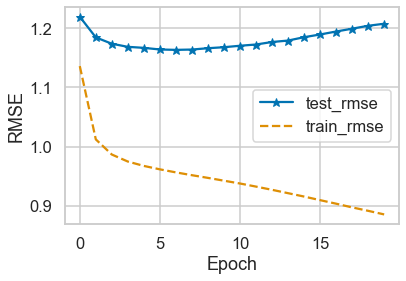

In [44]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_mlp = current_folder + '\\Pretrain\\toronto_MLP.h5'

train_loss = []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, user_feature_input, item_feature_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()
    
    # Training
    history = model.fit([user_input, item_input, user_feature_input, item_feature_input], # input
                         np.array(ratings), # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5) # multiply loss by 5 because the ratings are normalized by 5
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch + 1
        if out > 0:
            model.save_weights(model_out_file_mlp, overwrite = True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best MLP model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

# NCF Implementation:

In [45]:
def get_ncf_model(num_users, num_items, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='float32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='float32', name = 'item_input')
    user_feature_input = Input(shape = (num_of_features, ), dtype='float32', name = 'user_feature_input')
    item_feature_input = Input(shape = (num_of_features, ), dtype='float32', name = 'item_feature_input')
    
    # Embedding layer GMF
    MF_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = num_of_features, name = 'mf_embedding_user',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    MF_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = num_of_features, name = 'mf_embedding_item',
                                  embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf),
                                  input_length=1)
    
    # Embedding layer MLP
    MLP_Embedding_User_ID = Embedding(input_dim = num_users, output_dim = num_of_features, name = "mlp_embedding_user",
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item_ID = Embedding(input_dim = num_items, output_dim = num_of_features, name = 'mlp_embedding_item',
                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User_ID(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item_ID(item_input))
    
    mf_user_feature_latent = Multiply()([mf_user_latent, user_feature_input]) # Element-wise product - user
    mf_item_feature_latent = Multiply()([mf_item_latent, item_feature_input]) # Element-wise product - item
     
    mf_vector = Multiply()([mf_user_feature_latent, mf_item_feature_latent]) # Element-wise product of user and item

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User_ID(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item_ID(item_input))
    
    mlp_user_feature_latent = Multiply()([mlp_user_latent, user_feature_input]) # Element-wise product - user
    mlp_item_feature_latent = Multiply()([mlp_item_latent, item_feature_input]) # Element-wise product - item
    
    mlp_vector = Concatenate()([mlp_user_feature_latent, mlp_item_feature_latent]) # concatenation of embedding layers
    
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation = 'sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)
    
    model = Model(inputs = [user_input, item_input, user_feature_input, item_feature_input], outputs = prediction)
    
    return model

def load_pretrain_model(model, gmf_model, mlp_model, num_layers):
    # MF embeddings
    gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
    gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
    model.get_layer('mf_embedding_user').set_weights(gmf_user_embeddings)
    model.get_layer('mf_embedding_item').set_weights(gmf_item_embeddings)
    
    # MLP embeddings
    mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
    mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
    model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
    model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)
    
    # MLP layers
    for i in range(1, num_layers):
        mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
        model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('prediction').get_weights()
    mlp_prediction = mlp_model.get_layer('prediction').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
    return model

In [46]:
# Build and compile, and check initial performance
layers = layers.copy()
reg_layers = reg_layers.copy()
reg_mf = 0
mf_pretrain = model_out_file_gmf
mlp_pretrain = model_out_file_mlp

model = get_ncf_model(num_users, num_items, layers, reg_layers, reg_mf)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')

# Load pretrain model
if mf_pretrain != '' and mlp_pretrain != '':
    gmf_model = get_gmf_model(num_users,num_items)
    gmf_model.load_weights(mf_pretrain)
    mlp_model = get_mlp_model(num_users,num_items, layers, reg_layers)
    mlp_model.load_weights(mlp_pretrain)
    model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
    print("Load pretrained GMF and MLP models done.")
    
# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Load pretrained GMF and MLP models done.
Initial: Test RMSE = 1.1860, Test R2 = 0.1477


C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [3.1 s]: Test RMSE = 1.1638, Test R2 = 0.1793, Train RMSE = 0.9517 [0.1 s]
Epoch 2 [2.1 s]: Test RMSE = 1.1673, Test R2 = 0.1744, Train RMSE = 0.9397 [0.1 s]
Epoch 3 [2.4 s]: Test RMSE = 1.1684, Test R2 = 0.1728, Train RMSE = 0.9278 [0.1 s]
Epoch 4 [2.2 s]: Test RMSE = 1.1701, Test R2 = 0.1704, Train RMSE = 0.9138 [0.1 s]
Epoch 5 [2.5 s]: Test RMSE = 1.1744, Test R2 = 0.1643, Train RMSE = 0.8983 [0.1 s]
Epoch 6 [2.2 s]: Test RMSE = 1.1793, Test R2 = 0.1573, Train RMSE = 0.8824 [0.1 s]
Epoch 7 [2.2 s]: Test RMSE = 1.1833, Test R2 = 0.1516, Train RMSE = 0.8669 [0.1 s]
Epoch 8 [2.1 s]: Test RMSE = 1.1919, Test R2 = 0.1392, Train RMSE = 0.8517 [0.1 s]
Epoch 9 [2.4 s]: Test RMSE = 1.1983, Test R2 = 0.1298, Train RMSE = 0.8378 [0.1 s]
Epoch 10 [2.4 s]: Test RMSE = 1.2062, Test R2 = 0.1184, Train RMSE = 0.8247 [0.1 s]
Epoch 11 [2.2 s]: Test RMSE = 1.2152, Test R2 = 0.1052, Train RMSE = 0.8126 [0.1 s]
Epoch 12 [2.2 s]: Test RMSE = 1.2178, Test R2 = 0.1013, Train RMSE = 0.8010 [0.1 s]
E

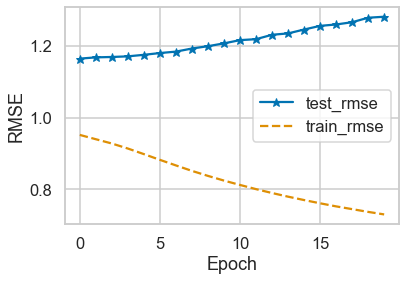

In [47]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_ncf = current_folder + '\\Pretrain\\toronto_NeuMF.h5'

train_loss, val_loss = [], []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, user_feature_input, item_feature_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()  
    
    # Training
    history = model.fit([user_input, item_input, user_feature_input, item_feature_input], # input
                         ratings, # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5)
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch
        if out > 0:
            model.save_weights(model_out_file_ncf, overwrite=True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter + 1, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best NeuMF model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

## Without Pretraining:

In [48]:
# Build and compile, and check initial performance
model = get_ncf_model(num_users, num_items, layers, reg_layers, reg_mf)

if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='mse')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='mse')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='mse')
    
# Initial performance
(mse, r2) = evaluate_model(model, X_test, y_test)
print('Initial: Test RMSE = %.4f, Test R2 = %.4f' % (np.sqrt(mse), r2))

Initial: Test RMSE = 1.7290, Test R2 = -0.8114


C:\ProgramData\Anaconda3\envs\cs_412\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1 [3.0 s]: Test RMSE = 1.2165, Test R2 = 0.1033, Train RMSE = 1.1298 [0.1 s]
Epoch 2 [2.4 s]: Test RMSE = 1.1855, Test R2 = 0.1484, Train RMSE = 1.0122 [0.1 s]
Epoch 3 [2.6 s]: Test RMSE = 1.1743, Test R2 = 0.1645, Train RMSE = 0.9876 [0.1 s]
Epoch 4 [2.3 s]: Test RMSE = 1.1721, Test R2 = 0.1675, Train RMSE = 0.9759 [0.1 s]
Epoch 5 [2.3 s]: Test RMSE = 1.1696, Test R2 = 0.1711, Train RMSE = 0.9662 [0.1 s]
Epoch 6 [2.3 s]: Test RMSE = 1.1666, Test R2 = 0.1753, Train RMSE = 0.9554 [0.1 s]
Epoch 7 [2.4 s]: Test RMSE = 1.1687, Test R2 = 0.1723, Train RMSE = 0.9428 [0.1 s]
Epoch 8 [2.3 s]: Test RMSE = 1.1670, Test R2 = 0.1747, Train RMSE = 0.9285 [0.1 s]
Epoch 9 [2.3 s]: Test RMSE = 1.1673, Test R2 = 0.1743, Train RMSE = 0.9136 [0.1 s]
Epoch 10 [2.4 s]: Test RMSE = 1.1686, Test R2 = 0.1725, Train RMSE = 0.8983 [0.1 s]
Epoch 11 [2.2 s]: Test RMSE = 1.1727, Test R2 = 0.1667, Train RMSE = 0.8835 [0.1 s]
Epoch 12 [2.2 s]: Test RMSE = 1.1788, Test R2 = 0.1581, Train RMSE = 0.8695 [0.1 s]
E

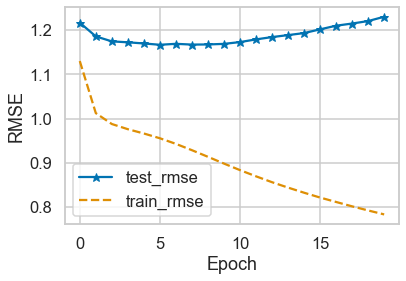

In [49]:
# Training and testing model
current_folder = os.getcwd()
model_out_file_ncf = current_folder + '\\Pretrain\\toronto_NeuMF_without_pretrain.h5'

train_loss, val_loss = [], []
test_rmse, test_r2 = [], []
best_mse = float('inf')

# Generate training instances
user_input, item_input, user_feature_input, item_feature_input, ratings = get_train_instances(X_train, y_train)

for epoch in range(num_epochs):
    t1 = time()
    
    # Training
    history = model.fit([user_input, item_input, user_feature_input, item_feature_input], # input
                         ratings, # labels
                         batch_size = batch_size, epochs = 1, verbose = 0)

    train_loss.append(np.sqrt(history.history['loss'][0]) * 5)
    
    t2 = time()

    # Evaluation
    (mse, r2) = evaluate_model(model, X_test, y_test)

    test_rmse.append(np.sqrt(mse))
    test_r2.append(r2)

    print('Epoch %d [%.1f s]: Test RMSE = %.4f, Test R2 = %.4f, Train RMSE = %.4f [%.1f s]' 
          % (epoch + 1,  t2 - t1, test_rmse[-1], test_r2[-1], train_loss[-1], time() - t2))

    if mse < best_mse:
        best_mse, best_r2, best_iter = mse, r2, epoch
        if out > 0:
            model.save_weights(model_out_file_ncf, overwrite=True)

print("End. Best Epoch %d:  RMSE = %.4f, R2 = %.4f. " %(best_iter + 1, np.sqrt(best_mse), best_r2))
if out > 0:
    print("The best NeuMF model is saved")
    
    
plt.plot(test_rmse, '*-', label = 'test_rmse')
plt.plot(train_loss, '--', label = 'train_rmse')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()